In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def make_switching_world(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorld(rates=rates, ntrials=ntrials)
    return world

def make_switching_world_withCheck(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorldWithCheck(rates=rates, ntrials=ntrials, threshold=0.8)
    return world

In [5]:
nblocks = 100

pswitchlst = np.linspace(0.01, 0.3, 25)
prewlst = np.linspace(0.5, 0.99, 20)

# prewlist = np.linspace(0.5, 1, 6)
# pswitchlistLog = np.linspace(np.log(0.01), np.log(0.2), 10)
# pswitchlist = np.exp(pswitchlistLog)
efflist = np.zeros((len(pswitchlst), len(prewlst)))

for i, prew in enumerate(prewlst):
    print(i)
    for j, pswitch in enumerate(pswitchlst):
        #print(i, j)
        world = make_switching_world_withCheck(0, 1, 100, 15, 25)

        agent = InferenceBasedAgent(prew=prew, pswitch=pswitch, type='random')

        exp = Experiment(agent, world)
        a,b = exp.run()  
        efflist[j,i] = agent.find_efficiency()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Foraging efficiency')

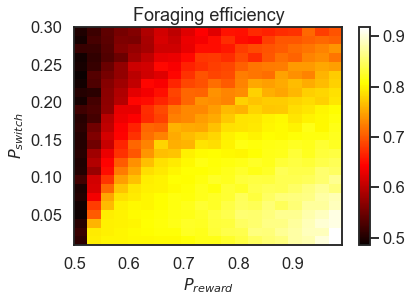

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(efflist, origin='lower', cmap='hot', aspect='auto',
              extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
fig.colorbar(im)

fontdict = {'fontsize': 16,
 'fontweight': 2}
# ax.set_xticks(pswitchlistLog[::3])
# ax.set_xticklabels(np.round(pswitchlist[::3], 2), fontdict)
# ax.set_yticks(np.linspace(min(prewlist), max(prewlist), 4))
# ax.set_yticklabels(np.linspace(min(prewlist), max(prewlist), 4), fontdict)

plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Foraging efficiency')



In [7]:
pswitchlst = np.linspace(0.01, 0.3, 25)
prewlst = np.linspace(0.5, 0.99, 20)
N_iters = 50
num_states = 2
obs_dim = 1
T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
for idsw, psw in enumerate(pswitchlst):
    print(psw)
    for idrew, prew in enumerate(prewlst):
        world = make_switching_world_withCheck(0, 1, 10, 15, 25)
        agent = InferenceBasedAgent(prew=prew, pswitch=psw, type='random')
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")

        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans")

        T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
        T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
        E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
    
                  

0.01



0.022083333333333333



0.034166666666666665



0.04625



0.058333333333333334



0.07041666666666667



0.08249999999999999



0.09458333333333332



0.10666666666666666



0.11875



0.13083333333333333



0.14291666666666666



0.155



0.16708333333333333



0.17916666666666667



0.19125



0.20333333333333334



0.21541666666666667



0.2275



0.23958333333333334



0.25166666666666665



0.26375



0.2758333333333333



0.28791666666666665



0.3


Text(0.5, 1.0, 'Transition probability')

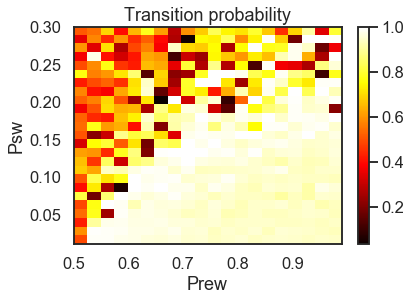

In [8]:
plt.imshow(T11lst, aspect='auto', origin='lower', cmap='hot',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)]
          )
plt.colorbar()
plt.xlabel('Prew')
plt.ylabel('Psw')
plt.title('Transition probability')

Text(0.5, 1.0, 'Action probability (right)')

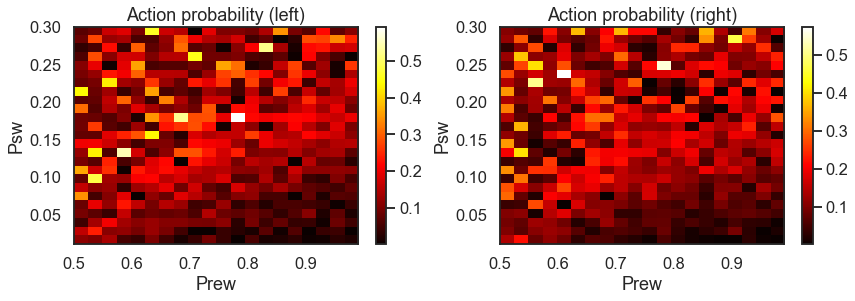

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.imshow(1-np.maximum(E1lst, E2lst), aspect='auto', origin='lower', cmap='hot',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel('Prew')
plt.ylabel('Psw')
plt.title('Action probability (left)')


plt.subplot(122)
plt.imshow(np.minimum(E1lst, E2lst), aspect='auto', origin='lower', cmap='hot',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel('Prew')
plt.ylabel('Psw')
plt.title('Action probability (right)')

/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


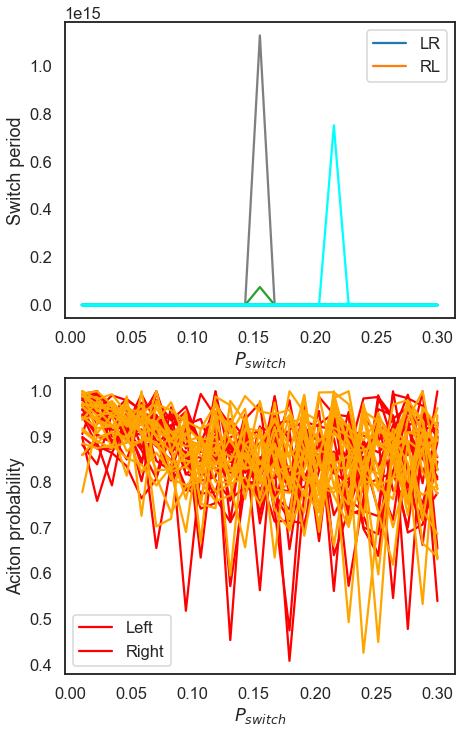

In [10]:
plt.figure(figsize=(7,12))
plt.subplot(211)
plt.plot(pswitchlst, 1/(1-np.array(T11lst)))
plt.plot(pswitchlst, 1/(1-np.array(T22lst)), color='cyan')
plt.xlabel(r'$P_{switch}$')
plt.ylabel('Switch period')
plt.legend(['LR', 'RL'])
plt.subplot(212)
plt.plot(pswitchlst, np.maximum(E1lst, E2lst), 'r')
plt.plot(pswitchlst, 1-np.minimum(E1lst, E2lst), color='orange')
plt.xlabel(r'$P_{switch}$')
plt.ylabel('Aciton probability')
plt.legend(['Left', 'Right'])
